In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics  import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import warnings
import statsmodels.api as sm
import scipy.stats as stats
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import scipy.stats as stats
import pmdarima as pm
import yfinance as yf

In [77]:
# Helpers

# Stationarity Test
def perform_adf_testing(adobe_stocks):
    # H0: Non-stationary
    # H1: Stationary
    print('Aadobe_stocks Test Result')
    print('---------------')
    for col in adobe_stocks.columns:
        result = adfuller(adobe_stocks[col])
        print(f'{col}:')
        print(f'Aadobe_stocks Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
        if result[1] < 0.05:
            print(f'{col} is stationary')
        else:
            print(f'{col} is non-stationary')
        print('---------------')


from statsmodels.tsa.stattools import kpss

def perform_kpss_testing(series, significance_level=0.05):
    # H0: Trend stationary
    # H1: Non-trend stationary
    print('KPSS Test Result')
    print('---------------')
    result = kpss(series)
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[1] < significance_level:
        print('The series is non-trend stationary')
    else:
        print('The series is trend stationary')
    print('---------------')



# Returns preparation
def returns_preparation_garch(adobe_stocks, target_var):
    adobe_stocks_copy = adobe_stocks.copy()
    adobe_stocks_copy['returns'] = adobe_stocks_copy[target_var].pct_change() * 100
    adobe_stocks_copy.dropna(inplace=True)
    adobe_stocks_copy['squared_returns'] = adobe_stocks_copy['returns']**2
    return adobe_stocks_copy

# When your p-value is less than or equal to your significance level, you reject the null hypothesis.


# Ljung-Box Test for Residuals
# Null Hypothesis (H0): The data are independently distributed, i.e., the correlations in the population from which the sample is taken are 0, so any observed correlations in the data result from randomness of the sampling process.
# Alternative Hypothesis (H1): The data are not independently distributed; they exhibit serial correlation.

def lb_test(residuals, lags):
    a = sm.stats.acorr_ljungbox(residuals, lags=lags)
    a_adobe_stocks = pd.DataFrame(a,columns=['lb_pvalue'])
    a_adobe_stocks.index = np.arange(1, len(a_adobe_stocks)+1)
    if a_adobe_stocks['lb_pvalue'].max() > 0.05:
        print('Residuals are independent')
    else:
        print('Residuals are not independent')
    return a_adobe_stocks




# Residuals Diagnostic custom method
def residuals_diagnostic(residuals):
    print('Mean of the residuals:', residuals.mean())
    # Plot residuals
    plt.figure(figsize=(10,4))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.show()

    # ACF plot
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.show()

    # Histogram and Q-Q plot
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.hist(residuals, bins=25, density=True, alpha=0.6, color='b')
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(residuals)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title('Histogram')

    plt.subplot(122)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot')

    plt.tight_layout()
    plt.show()


# Best Garch Model selection
def best_garch(adobe_stocks, return_col = 'returns', p_max = 4, q_max = 4):
    best_aic = float("inf")
    best_p = None
    best_q = None
    best_garch_model = None

    for p in range(1, p_max):
        for q in range(1, q_max):
            garch_model = arch_model(
                adobe_stocks[return_col],
                mean='Zero',
                vol='GARCH',
                p=p,
                q=q,
                # dist='StudentsT'
            ).fit(disp='off')
            
            aic = garch_model.aic
            # mse = garch_model.mse
            # print(f'GARCH({p},{q}) MSE: {mse:.2f} AIC: {aic:.2f}')


            if aic < best_aic:
                best_p = p
                best_q = q
                best_aic = aic
                best_garch_model = garch_model

    print(f"The best garch model is: GARCH({best_p,best_q})\n",best_garch_model.summary())
    return (best_garch_model, (best_p, best_q))


# !TODO KPSS test

In [78]:
adbe_ticker = yf.Ticker('ADBE')

In [79]:
adobe_stocks = adbe_ticker.history(period="3y")
adobe_stocks.index = pd.to_datetime(adobe_stocks.index, format='%Y-%m-%d')

# Data Loading and Preparation

In [80]:
# Additional Filtering (if needed)
adobe_stocks = adobe_stocks[adobe_stocks.index > '2021-01-01']

# Plotting the target Variable

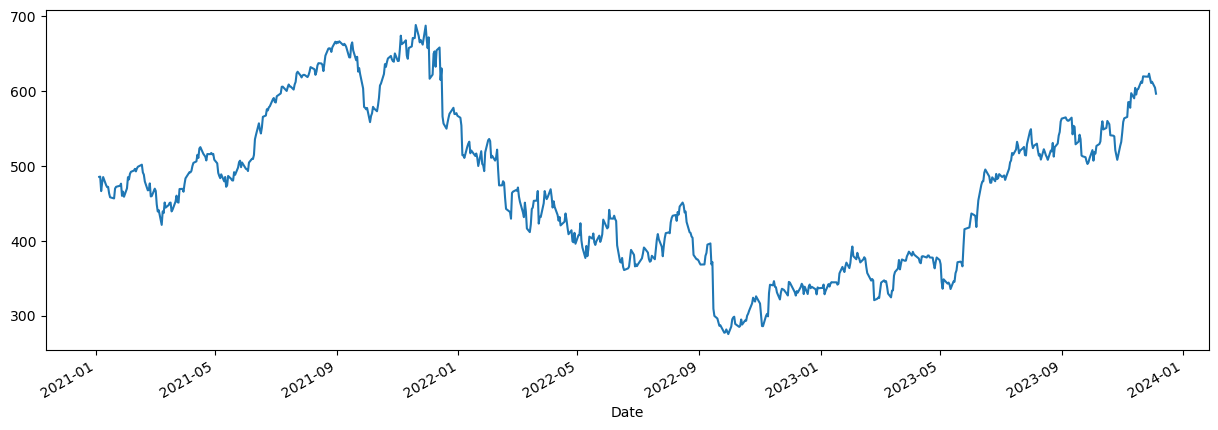

In [81]:
target_col = 'Close'
adobe_stocks[target_col].plot(figsize=(15,5));

We can observe an increasing trend and at around the end of 2021 beginning of 2022, Adobe stock price reached its peak value. As per the news article, there was a release of the Cloud express platform near that time period, (https://news.adobe.com/news/news-details/2021/Adobe-Introduces-Creative-Cloud-Express/default.aspx), also in November Adobe signed multiple deals with sports clubs and leagues. Another notable event was the acquisition of frame.io. Later on we can see that around October 2022, the price reached its minimum in the provided period, during that time most of the IT companies were laying off their employees, but Adobe was amongsth the companies with the lowest number of lay offs in that period, which may be a leading indicator for the decrease. Throughout 2023, the prices seemed to be increasing and reached a unit very close to the maximal around the end of the year.

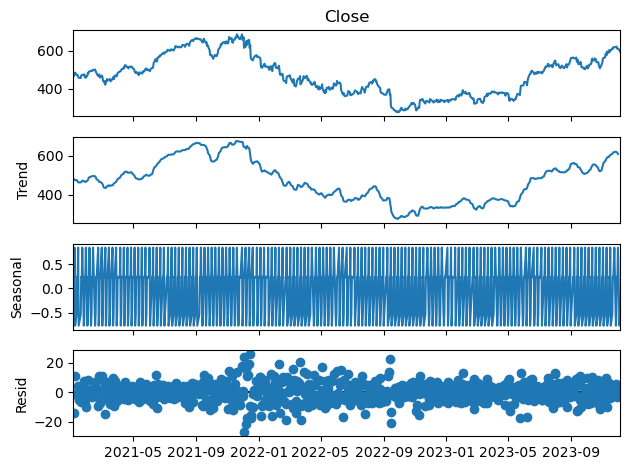

In [82]:
seasonal_decompose(adobe_stocks[target_col], model='additive', period=5).plot();

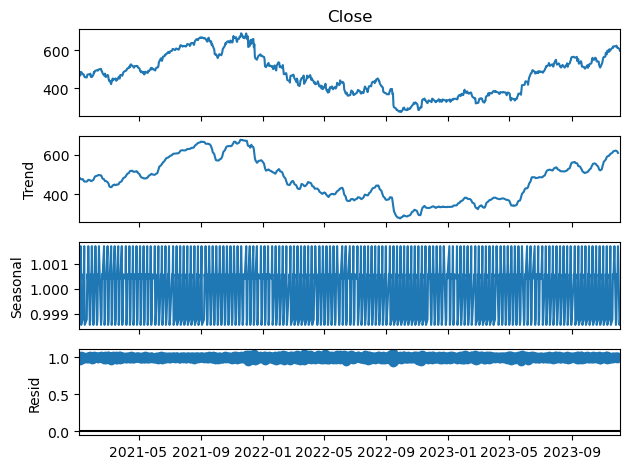

In [83]:
seasonal_decompose(adobe_stocks[target_col], model='multiplicative', period=5).plot();

We can clearly observe that the target variable is not stationary. It has an additive trend for decreasing during the 2022 year till the 7th month, but after that the price for a unit of ADOBE stock, started to rise a little. After October 2022, we can see an increasing additive trend till 2023 October. There are no signs of seasonality in the the series. As per the seasonality, trend analysis our series is likely to have an additive trend, as the residuls of the additive detrending resemble a white noise distribution.

In [103]:
target_col = 'Close'
as_returns = returns_preparation_garch(adobe_stocks, target_col)
as_returns.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,squared_returns
Date,,,,,,,,,
2021-01-05 00:00:00-05:00,485.880005,486.079987,479.200012,485.690002,2010100,0.0,0.0,0.072116,0.005201
2021-01-06 00:00:00-05:00,474.100006,475.869995,466.000000,466.309998,4156600,0.0,0.0,-3.990200,15.921700
2021-01-07 00:00:00-05:00,471.000000,479.640015,468.250000,477.739990,2901200,0.0,0.0,2.451158,6.008173
2021-01-08 00:00:00-05:00,480.000000,485.540009,477.209991,485.100006,2266100,0.0,0.0,1.540590,2.373418
2021-01-11 00:00:00-05:00,481.989990,482.589996,471.299988,474.239990,2382400,0.0,0.0,-2.238717,5.011853
2021-01-12 00:00:00-05:00,474.410004,475.000000,464.000000,471.649994,2964900,0.0,0.0,-0.546136,0.298265
2021-01-13 00:00:00-05:00,472.000000,477.850006,469.299988,472.049988,2105900,0.0,0.0,0.084807,0.007192
2021-01-14 00:00:00-05:00,472.410004,473.549988,462.200012,463.269989,3508300,0.0,0.0,-1.859972,3.459497
2021-01-15 00:00:00-05:00,462.500000,467.880005,457.489990,458.079987,3200400,0.0,0.0,-1.120298,1.255067


In [104]:
train_index = int(0.80 * len(as_returns))
as_returns_train = as_returns[:train_index]
as_returns_test = as_returns[train_index:]

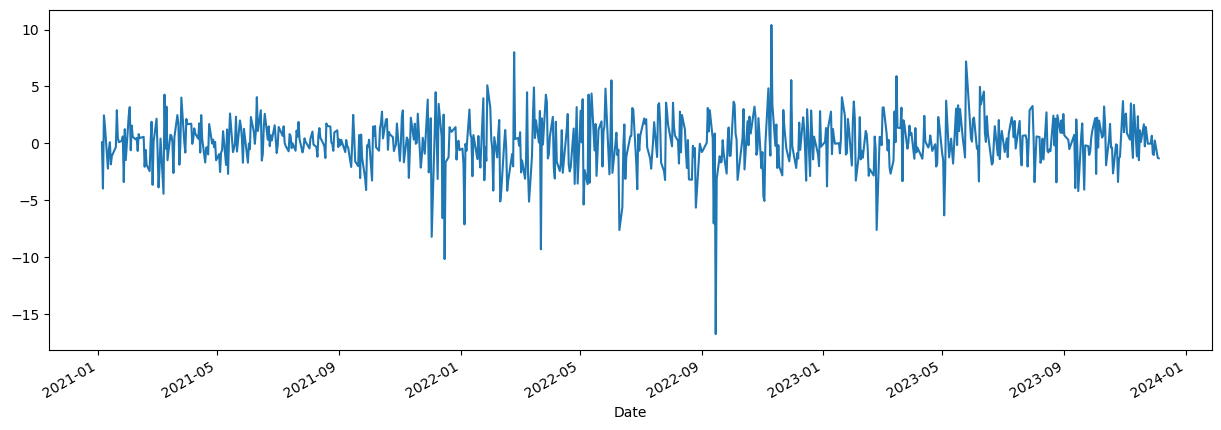

In [105]:
as_returns['returns'].plot(figsize=(15,5));

We can observe that the returns series is stationary as it is more or less constantly reaching the expected mean, which is 0 in this case.

In [106]:
perform_adf_testing(adobe_stocks['Close'].to_frame())
perform_adf_testing(as_returns['returns'].to_frame())

Aadobe_stocks Test Result
---------------
Close:
Aadobe_stocks Statistic: -1.085442112556438
p-value: 0.7208423695675943
Critical Values:
	1%: -3.4392782790913206
	5%: -2.865480319267325
	10%: -2.568868260909806
Close is non-stationary
---------------
Aadobe_stocks Test Result
---------------
returns:
Aadobe_stocks Statistic: -26.006798805491915
p-value: 0.0
Critical Values:
	1%: -3.439290485895927
	5%: -2.8654856985173414
	10%: -2.568871126669587
returns is stationary
---------------


The results from the adf-test approve our findings from the visualizations

# ACF PACF Diagnostics

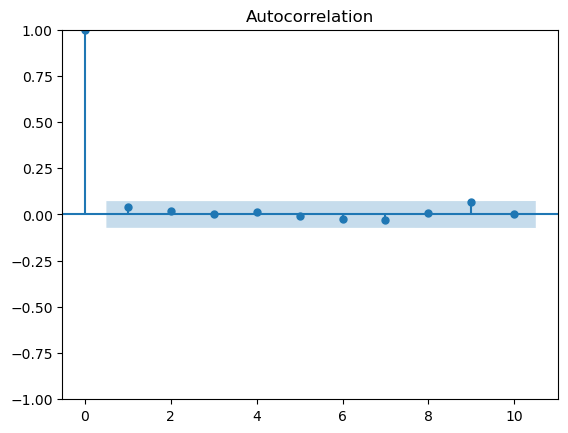

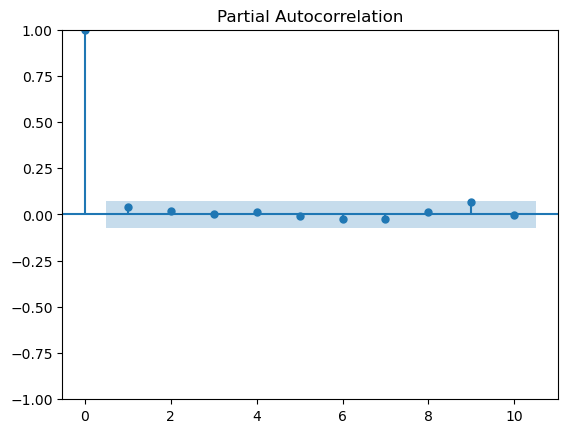

In [107]:
ACF_LAGS = 10
PACF_LAGS = 10

plot_acf(as_returns['returns'], lags=ACF_LAGS);
plot_pacf(as_returns['returns'], lags=PACF_LAGS);

The visualizations for the ACF and PACF of the returns series, indicate that there are no significant lags in the returns series, thus we are most likely dealing with a white noise, having that we should consider an acf/pacf diagnostics of the returns ^ 2 series. As, no signs of an ARMA process is visible, I will skip the ARMA modelling part on the original returns.

In [108]:
# Returns Variations next steps
# If no signifcant lags
def no_lags(adobe_stocks, returns_col = 'returns'):
    adobe_stocks_copy = adobe_stocks.copy()
    adobe_stocks_copy.dropna(inplace=True)
    adobe_stocks_copy['returns_squared'] = adobe_stocks_copy[returns_col]**2
    # adobe_stocks_copy['returns_squared'].plot(figsize=(15,5));
    plot_acf(adobe_stocks_copy['returns_squared'], lags=ACF_LAGS, title="ACF of Squared Returns");
    plot_pacf(adobe_stocks_copy['returns_squared'], lags=PACF_LAGS, title="PACF of Squared Returns");

# If ARMA model is present 
def sig_lags(adobe_stocks, returns_col = 'returns', arma_order = (1,1)):
    #TODO Determine the actions
    #FIT an ARMA model and work on RESIDUALS
    pass

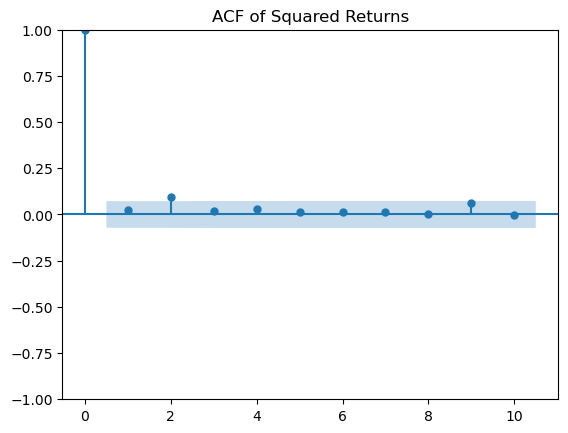

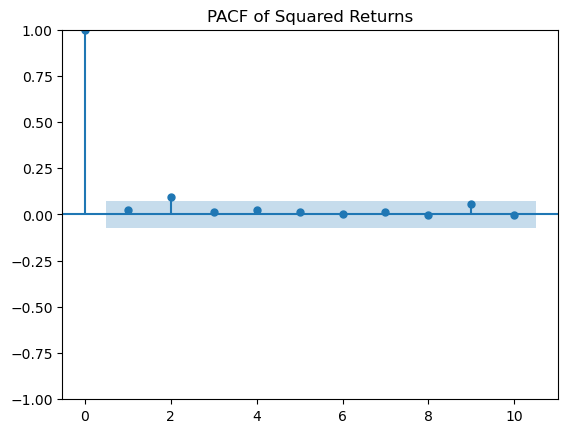

In [109]:
no_lags(as_returns['returns'].to_frame())

When we perform an ACF/PACF diagnostics on the returns squared, we can observe that the second lag is significant both for the ACF and PACF. Let's proceed with fitting a GARCH(1,1) model for the series.

In [110]:
# Best GARCH loop
best_garch_model, GARCH_ORDER = best_garch(as_returns_train, return_col = 'returns', p_max = 4, q_max = 4)

The best garch model is: GARCH((2, 1))
                        Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1301.70
Distribution:                  Normal   AIC:                           2611.41
Method:            Maximum Likelihood   BIC:                           2628.92
                                        No. Observations:                  588
Date:                Tue, Dec 05 2023   Df Residuals:                      588
Time:                        20:22:34   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          

The for loop approach suggest to use GARCH(2,1), when minimized with AIC,BIC.

Mean of the residuals: -0.02810413103717166


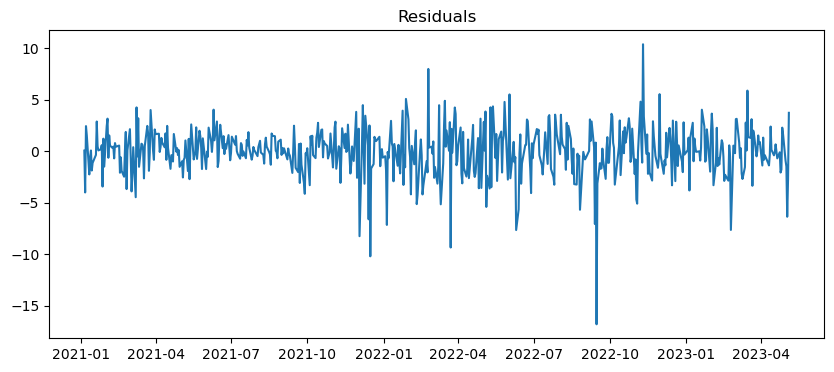

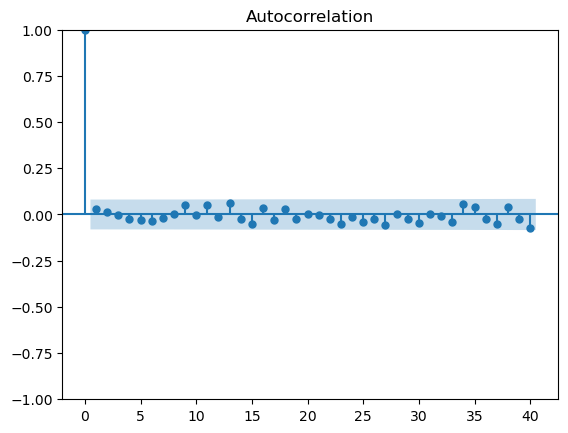

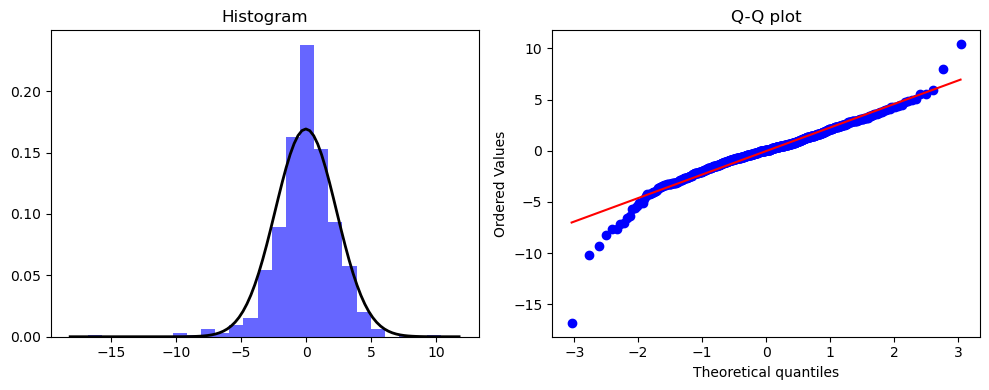

Residuals are independent


,lb_pvalue
1,0.459649
2,0.730335
3,0.889483
4,0.909660
5,0.909494
6,0.895554
7,0.932858
8,0.964569
9,0.912527
10,0.948061


In [111]:
best_garch_residuals = best_garch_model.resid
residuals_diagnostic(best_garch_residuals)
lb_test(best_garch_residuals, 10)

The residual diagnostics of the garch model, show that they follow a normal/white noise distribution, so we are good to proceed.

In [112]:
best_garch_model = arch_model(as_returns_train['returns'], p = GARCH_ORDER[0], q = GARCH_ORDER[1], mean='Zero', dist='Normal').fit(disp='off')
as_returns_train['best_garch_volatility'] = list(best_garch_model.conditional_volatility)
# manual_garch_model = arch_model(as_returns_train['returns'], p = 1, q = 1).fit(disp='off')
# as_returns_train['manual_garch_volatility'] = list(manual_garch_model.conditional_volatility)

print("MSE of best garch model:", mean_squared_error(as_returns_train['squared_returns'], as_returns_train['best_garch_volatility']))
# print("MSE of manual garch model:", mean_squared_error(as_returns_train['squared_returns'], as_returns_train['manual_garch_volatility']))

MSE of best garch model: 250.97077710775733


In [113]:
forecasts = best_garch_model.forecast(horizon=len(as_returns_test)).variance.values[-1,:]
volatility = np.sqrt(forecasts)
as_returns_test['best_garch_volatility'] = volatility

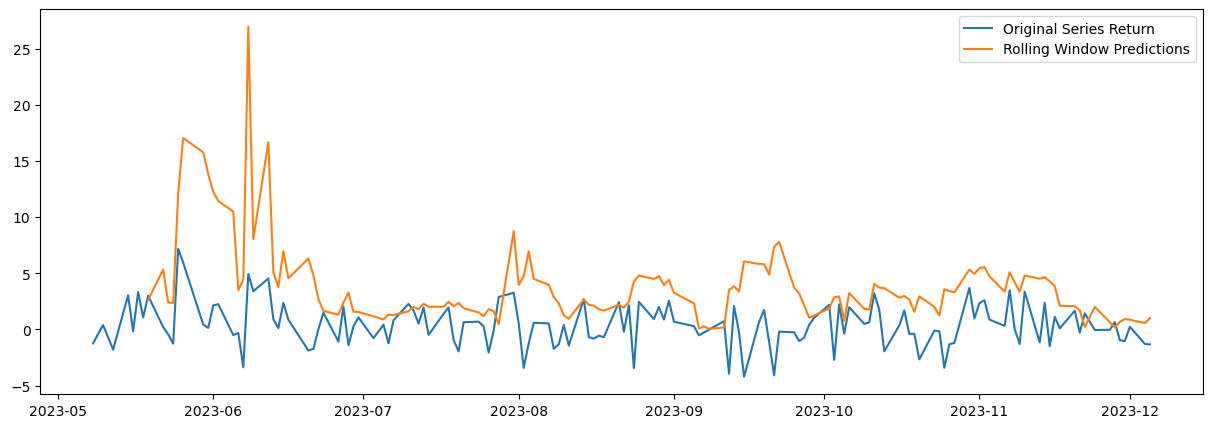

In [114]:
# # Define the window size
# window_size = 10

# # Create an empty list to store the predictions
# predictions = []

# for i in range(len(as_returns_test) - window_size + 1):
#     window = as_returns_test.iloc[i:i+window_size]
#     model = arch_model(window['returns'], p=GARCH_ORDER[0], q=GARCH_ORDER[1], mean='Zero', dist='Normal').fit(disp='off')
    
#     # Forecast the volatility for the next time step
#     forecast = model.forecast(horizon=1).variance.values[-1, 0]
    
#     # Append the forecast to the predictions list
#     predictions.append(forecast)

# # Convert the predictions list to a pandas Series
# predictions = pd.Series(predictions, index=as_returns_test.index[window_size-1:])

# # Plot the original series and the predicted volatility
# plt.figure(figsize=(15, 5))
# plt.plot(as_returns_test['returns'], label='Original Series Return')
# plt.plot(predictions, label='Rolling Window Predictions')
# plt.legend()
# plt.show()


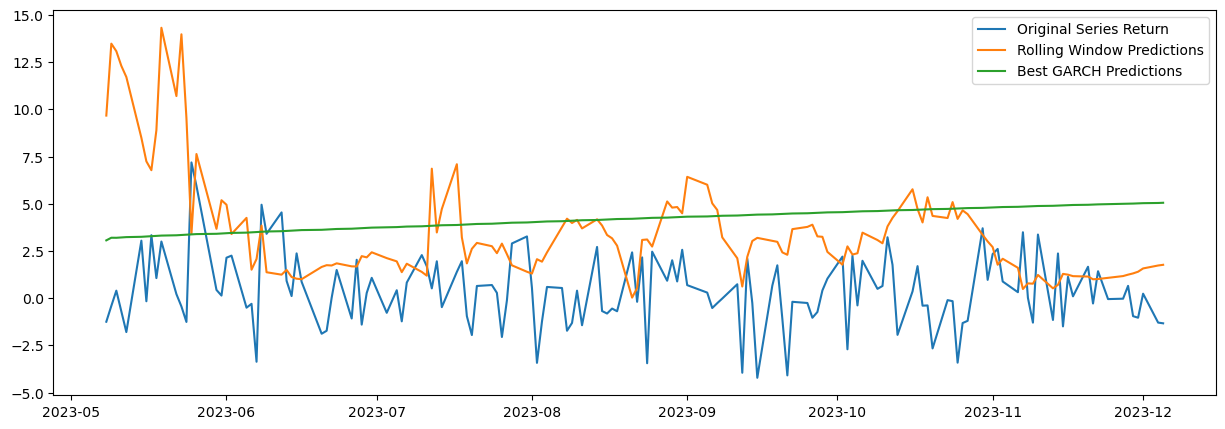

In [130]:
def rolling_window_predictions(test_series, garch_order = GARCH_ORDER):
    window_size = int(len(test_series) / 10)
    predictions = []
    residuals = []
    for i in range(len(test_series)):
        window = test_series.iloc[i:i+window_size]
        model = arch_model(window, p=garch_order[0], q=garch_order[1], mean='Zero', dist='Normal').fit(disp='off')
        forecast = model.forecast(horizon=window_size).variance.values[-1, 0]
        residuals.append(model.resid)
        predictions.append(forecast)
    
    return (
        pd.DataFrame(predictions, index=test_series.index, columns=['volatility']),
        residuals
    )

predictions,rolling_residuals = rolling_window_predictions(as_returns_test['returns'], )
as_returns_test['rolling_window_volatility'] = predictions

# Plot the original series and the predicted volatility
plt.figure(figsize=(15, 5))
plt.plot(as_returns_test['returns'], label='Original Series Return')
plt.plot(as_returns_test['rolling_window_volatility'], label='Rolling Window Predictions')
plt.plot(as_returns_test['best_garch_volatility'], label='Best GARCH Predictions')
plt.legend()
plt.show()



In [120]:
mean_squared_error(as_returns_test['squared_returns'], as_returns_test['rolling_window_volatility'])

51.31849422357216

In [119]:
mean_squared_error(as_returns_test['squared_returns'], as_returns_test['best_garch_volatility'])

44.56133303634661

Altough we can see that with the rolling window approach, we are able to capture the the volatility better and the GARCH model that was fitted on the training test, is just predicting the expected value for the test set, instead of some generalization, the MSE of the underfitted data is still lower than the approach with the rolling windows.

In [135]:
combined_residuals = pd.concat(rolling_residuals)
mean_residuals = combined_residuals.groupby(combined_residuals.index).mean()

Mean of the residuals: 0.38438765778924505


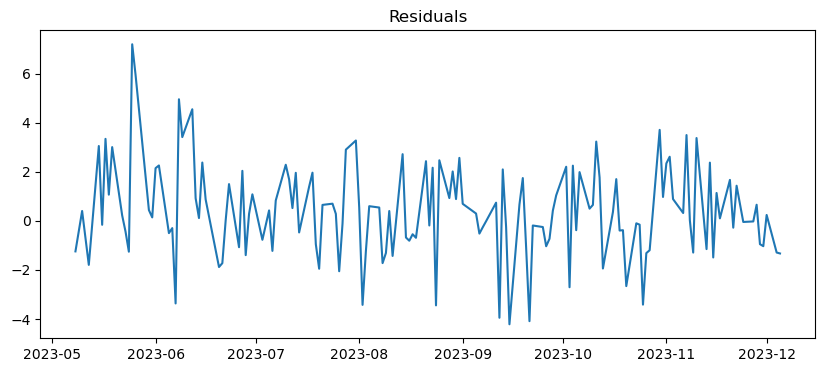

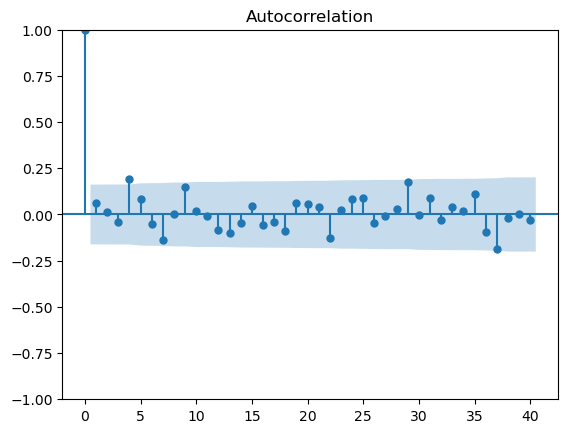

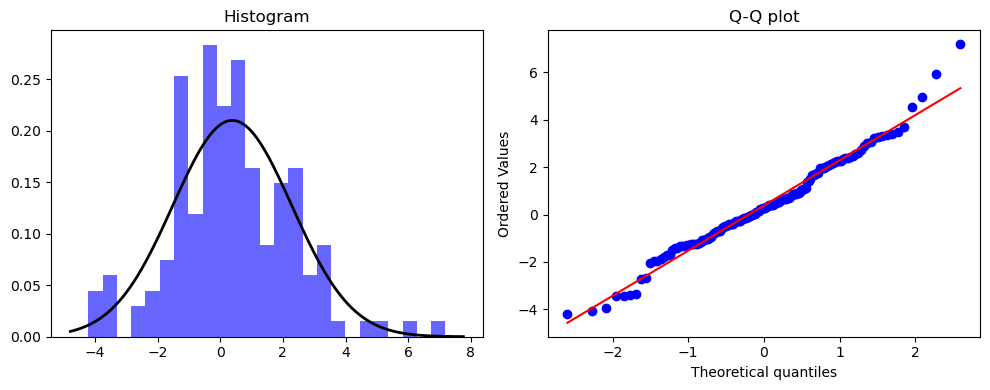

In [137]:
residuals_diagnostic(mean_residuals)

In [138]:
lb_test(mean_residuals, 10)

Residuals are independent


,lb_pvalue
1,0.433383
2,0.726472
3,0.833008
4,0.156708
5,0.169753
6,0.227088
7,0.129008
8,0.189151
9,0.099877
10,0.141991


The residuals of the rolling window predictions approach resemble a white noise, so we do not have any information left in the error.

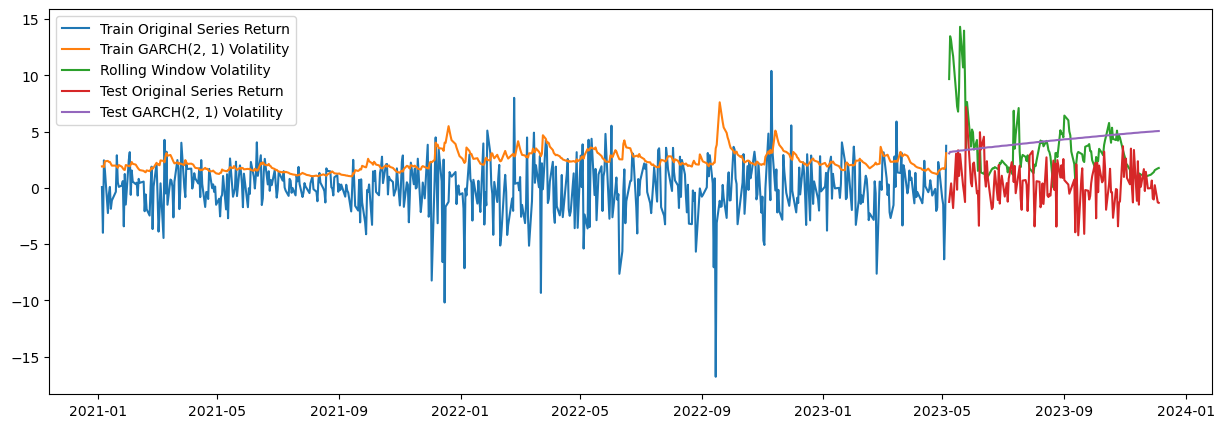

In [98]:
import calendar
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(as_returns_train['returns'], label='Train Original Series Return')
plt.plot(as_returns_train['best_garch_volatility'], label=f'Train GARCH{GARCH_ORDER} Volatility')
plt.plot(as_returns_test['rolling_window_volatility'], label='Rolling Window Volatility')
plt.plot(as_returns_test['returns'], label='Test Original Series Return')
plt.plot(as_returns_test['best_garch_volatility'], label=f'Test GARCH{GARCH_ORDER} Volatility')

# Add release date indicator
release_dates = []
for year in range(as_returns.index.year.min(), as_returns.index.year.max() + 1):
    for month in range(1, 13):
        if month != 11 and month != 12:
            last_thursday = max(week[-1] for week in calendar.monthcalendar(year, month))
            release_dates.append(pd.Timestamp(year=year, month=month, day=last_thursday))

for release_date in release_dates:
    plt.axvline(x=release_date, color='red', linestyle='--', alpha=0.5)

plt.legend()
plt.show()


Adobe, has no releases during the months of November and December, due to the holidays period in USA. We can see that our predictions do not capture the volatility very good in that period, meaning that during a no release period the stock prices are expected to stay the same.